---
title: "LAMMPS gcmc with umbrella"
format:
  pdf:
    toc: False
    number-sections: true
    colorlinks: true
---


I test liquid-gas coexistenc in LAMMPS with my custom `gcc/umbrella` fix.
I take a small LJ system in a volume $V=8^3\sigma^3$ and test it at the $\beta\mu$ given by MC

I place a quadratic umbrella with weight

$$w(n) = \exp\left[-\dfrac{k(n-n_0)^2}{2T}\right]$$

where $n$ is the number of particles. It is centerd at $n_0=150$ with $k=0.0005$.

I run `lammmps` in a hybrid GCMC coupled to a constant temperature thermostat (which shouls correctly take into account the change of particles).


First I load the outputs for teh density.

In [145]:
import numpy as np
import matplotlib.pyplot as plt

In [146]:
data = np.loadtxt("n-betamu-3.092-T1.txt")

Text(0, 0.5, '$\\rho$')

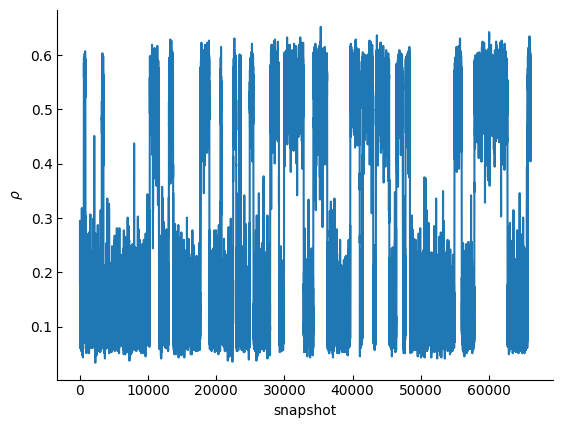

In [147]:
plt.plot(data[:,1])
plt.xlabel("snapshot")
plt.ylabel(r"$\rho$")

The simulation correctly jumps from one phase to the other.

I can check the PDFs and apply an unbiasing.

/var/folders/lt/p1n6bb0j4_173x9548b473jh0000gn/T/ipykernel_71458/1092576372.py:7: RuntimeWarning: divide by zero encountered in log
  F = np.log(h)


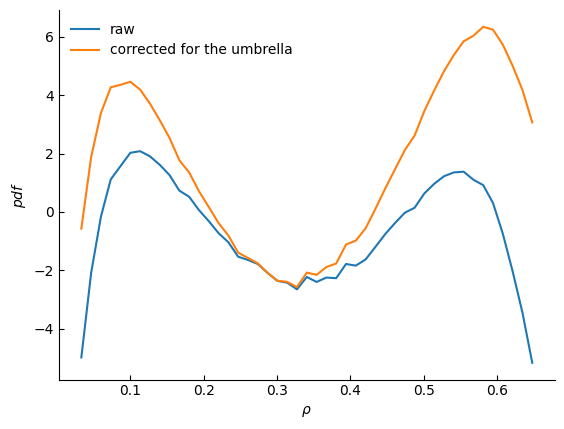

In [149]:
# consider the pdf and the umbrella
Vol = L**3
rhos = np.linspace(0,data[:,0].max()+1)/Vol
# print(rhos, rhos.max())
h,edges = np.histogram(data[:,1],bins=rhos, density=True)
rho = edges[:-1]+0.5*(edges[1]-edges[0])
F = np.log(h)

plt.plot(rho,F,label='raw')

# umbrella
k, n0 = 0.0005,150
L = 8.0

T = 1.0 

umbrella = - 0.5/T*k*(rho*Vol-n0)**2

plt.plot(rho,F-umbrella,label='corrected for the umbrella')
plt.xlabel(r"$\rho$")
plt.ylabel(r"$pdf$")

plt.legend()

The peaks are unequal. Maybe I can estimate a correction to the chemical potential?

In [156]:
def objective(dmu, original_F=None,rho=None,mid=0.3,Volume=1.):
    N= rho*Volume
    F = original_F+dmu*N
    val = (F[rho<mid].max()-F[rho>mid].max())**2
    return val


# objective(0,F-V, rho=rho,V=V)
from scipy.optimize import minimize_scalar

res = minimize_scalar(objective,args=(F-umbrella,rho,0.3,Vol))
res.x
betamu = -3.092
print(f"The correction dmu is {res.x} which is {res.x/betamu} of the original value")

The correction dmu is -0.0076565803405382795 which is 0.0024762549613642558 of the original value


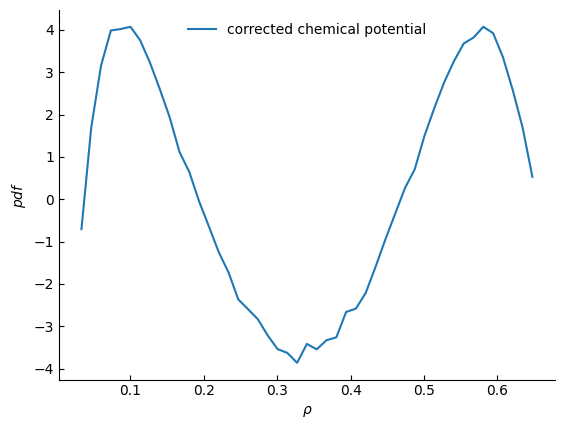

In [157]:
plt.plot(rho,F-umbrella+res.x*rho*Vol,label='corrected chemical potential')
plt.xlabel(r"$\rho$")
plt.ylabel(r"$pdf$")
plt.legend()
